# 2. Regression

### TODO: 
- dimensions reduce
- feature selection
- maxmin scaler


In [1]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor


from sklearn.model_selection import *
from sklearn.metrics import *

In [2]:
#data processiong tools
def normalize_data(X_train, X_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)    
    return X_train, X_test

def encode_labels(x_train, x_test, cols=None):
    label_encoder = sklearn.preprocessing.LabelEncoder()
    if cols == -1:#only encode last col
        x_train.iloc[:] = label_encoder.fit_transform(x_train.iloc[:])
        x_test.iloc[:] = label_encoder.transform(x_test.iloc[:])
    else:
        for i,t in enumerate(x_train.dtypes):
            if t == 'object':
                label_encoder.fit(df.iloc[:,i])
                x_train.iloc[:,i] = label_encoder.transform(x_train.iloc[:,i])
                x_test.iloc[:,i] = label_encoder.transform(x_test.iloc[:,i])           
    return x_train, x_test

#put class colunmn at end of dataframe
def put_class_col_end(dataFrame):
    cols = dataFrame.columns.tolist()
    cols = cols[1:] + cols[:1]
    return dataFrame[cols]

#impute ? with given strategy
def impute_value(x_train, x_test, strategy):
    try:
        x_train = x_train.replace({'?' : np.nan})
        x_test = x_test.replace({'?' : np.nan})
    except:
        print('no question mark found')
    if strategy == None:
        return x_train.dropna(), x_test.dropna()
    else:
        imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
        train_type_dic = dict()#save original train data type before impute
        for i,t in enumerate(x_train.dtypes):
            if t != 'object':
                train_type_dic[i] = t
        test_type_dic = dict()#save original test data type before impute
        for i,t in enumerate(x_test.dtypes):
            if t != 'object':
                test_type_dic[i] = t        
        x_train = pd.DataFrame(imp.fit_transform(x_train))
        x_test = pd.DataFrame(imp.transform(x_test))
        for key in train_type_dic:
            x_train.iloc[:,key] = x_train.iloc[:,key].astype(train_type_dic[key])
        for key in test_type_dic:
            x_test.iloc[:,key] = x_test.iloc[:,key].astype(test_type_dic[key])
        return x_train, x_test

In [3]:
def plot_all(X_train, y_train, X_test, y_test, all_regrs, regr_names):
    plt.figure(figsize=(18,8))
    ax1 = plt.subplot(121)
    mse_scores = plot_mse_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax1)
    ax2 = plt.subplot(122)
    r2_scores = plot_r2_score(X_train, y_train, X_test, y_test, all_regrs, regr_names,ax2)
    plt.savefig(IMAGE_PATH+file.split('.')[0]+'_mse-r2')
    plt.show()

def plot_mse_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax):
    mse_scores = dict()
    training_scores = []
    test_scores = []
    
    for regr, regr_name in zip(all_regrs, regr_names):
        train_preds = regr.predict(X_train)
        test_preds = regr.predict(X_test)
#         if y_test.dtype == 'int64' or y_test.dtype == 'int32':
#             train_preds = [round(p) for p in train_preds]
#             test_preds = [round(p) for p in test_preds]
        train_score = sklearn.metrics.mean_squared_error(y_train, train_preds)
        test_score = sklearn.metrics.mean_squared_error(y_test, test_preds)
        training_scores.append(train_score)
        test_scores.append(test_score)
        mse_scores[regr_name] = test_score
        
    N = len(all_regrs)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    p1 = plt.barh(ind-width/2, training_scores, align='center', label='Training Set', height=width)
    p2 = plt.barh(ind+width/2, test_scores, align='center', label='Test Set', height=width)
    for i, v in enumerate(training_scores):
        plt.text(v+0.07,ind[i]-width/2.5,'%.3f'%v)
        plt.text(test_scores[i]+0.07,ind[i]+width/1.5,'%.3f'%test_scores[i])
        
    plt.yticks(ind, regr_names) 
    plt.xlabel('MSE')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title('Mean Squared Error Of All Regressors')
    plt.legend(handles=[p1,p2])
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
#     ax.yaxis.tick_right()
    return mse_scores

def plot_r2_score(X_train, y_train, X_test, y_test, all_regrs, regr_names, ax):
    r2_scores = dict()
    training_scores = []
    test_scores = []
    
    for regr, regr_name in zip(all_regrs, regr_names):
        train_preds = regr.predict(X_train)
        test_preds = regr.predict(X_test)
#         if y_test.dtype == 'int64' or y_test.dtype == 'int32':
#             train_preds = [round(p) for p in train_preds]
#             test_preds = [round(p) for p in test_preds]
        train_score = sklearn.metrics.r2_score(y_train, train_preds)
        test_score = sklearn.metrics.r2_score(y_test, test_preds)
        training_scores.append(train_score)
        test_scores.append(test_score)
        r2_scores[regr_name] = test_score
        
    N = len(all_regrs)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

#     p1 = plt.bar(ind, training_scores, width)
#     p2 = plt.bar(ind+width, test_scores, width)
#     plt.ylabel('Scores')
#     plt.title('Scores by group and gender')
#     plt.xticks(ind, regr_names,rotation='vertical')
#     plt.yticks(np.arange(0, 1.1, 0.1))
#     plt.legend((p1[0], p2[0]), ('Training', 'Test'))

    p1 = plt.barh(ind-width/2, training_scores, align='center', label='Training Set', height=width)
    p2 = plt.barh(ind+width/2, test_scores, align='center', label='Test Set', height=width)
    for i, v in enumerate(training_scores):
        plt.text(v+0.01,ind[i]-width/2.5,'%.3f'%v)
        plt.text(max(test_scores[i],0)+0.01,ind[i]+width/1.5,'%.3f'%test_scores[i])

    plt.yticks(ind, regr_names)
    plt.xlabel('R² Score')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title('R² Scores Of All regressors')
    plt.legend(handles=[p1,p2])
    plt.gca().invert_yaxis()
#     plt.gca().invert_xaxis()
    ax.yaxis.tick_right()
    return r2_scores

In [4]:
# scipy.stats.randint(1,20)
# scipy.stats.reciprocal(1.0, 100.),
# scipy.stats.uniform(0.75, 1.25),
def train_SVR(X_train, y_train):
    print('Training SVR ...')
    svr = SVR()
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 10.),
        'epsilon' : scipy.stats.uniform(0.1, 0.5),
        'gamma' : scipy.stats.reciprocal(0.01, 0.1),
    }
    randcv = RandomizedSearchCV(svr,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeRegressor(random_state=0)
    param_distributions = {
        'max_depth' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestRegressor(random_state=0, warm_start=True)
    param_distributions = {
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostRegressor(random_state=0)
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,100)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_GaussianProcess(X_train, y_train):
    print('Training GaussianProcess ...')
    kernel = DotProduct()
    gaussian = GaussianProcessRegressor(kernel=None, normalize_y=True, random_state=0)
    param_distributions = {
        'n_restarts_optimizer' : scipy.stats.randint(0,10),
        'alpha' : scipy.stats.uniform(1e-9, 1e-8)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(gaussian,param_distributions,n_iter=10,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_LinearRegression(X_train,y_train):
    print('Training LinearRegression ...')
    linear = LinearRegression(normalize=True, n_jobs=-1)
    param_distributions = {
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(linear,param_distributions,n_iter=30,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPRegressor(solver='adam', random_state=0, warm_start=True, activation='tanh')
    param_distributions = {
        'activation' : ['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes' : [(100,50,25),(200,100,50),(200,100,50,25)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(nn,param_distributions,n_iter=15,cv=3,n_jobs=-1,
                                                        iid=False,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv

In [5]:
#data sets
DATA_PATH = 'dataset/'
IMAGE_PATH = 'image/'
files = []
dfs = []

file1 = 'winequality-red.csv'
df1 = pd.read_csv(DATA_PATH+file1, delimiter=';',header=0)
dfs.append(df1)
files.append(file1)

file1_2 = 'winequality-white.csv'
df1_2 = pd.read_csv(DATA_PATH+file1_2, delimiter=';',header=0)
dfs.append(df1_2)
files.append(file1_2)

# file2 = 'communities.data'
# df2 = pd.read_csv(DATA_PATH+file2, delimiter=',', header=None)


In [6]:
def run_all_regrs(X_train, y_train, X_test, y_test):
    all_regrs = []
    regr_names = []

    regr1 = train_SVR(X_train, y_train)
    all_regrs.append(regr1.best_estimator_)
    regr_names.append('SVR')

    regr2 = train_DecisionTree(X_train, y_train)
    all_regrs.append(regr2.best_estimator_)
    regr_names.append('Decision Tree')

    regr3 = train_RandomForest(X_train, y_train)
    all_regrs.append(regr3.best_estimator_)
    regr_names.append('Random Forest')

    regr4 = train_AdaBoost(X_train, y_train)
    all_regrs.append(regr4.best_estimator_)
    regr_names.append('AdaBoost')

    regr5 = train_GaussianProcess(X_train, y_train)
    all_regrs.append(regr5.best_estimator_)
    regr_names.append('Gaussian Process')

    regr6 = train_LinearRegression(X_train, y_train)
    all_regrs.append(regr6.best_estimator_)
    regr_names.append('Linear Regression')

    regr7 = train_NeuralNetwork(X_train, y_train)
    all_regrs.append(regr7.best_estimator_)
    regr_names.append('NeuralNetwork')

    plot_all(X_train, y_train, X_test, y_test, all_regrs, regr_names)
    return all_regrs, regr_names

Training SVR ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training GaussianProcess ...
Training LinearRegression ...
Training NeuralNetwork ...


/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


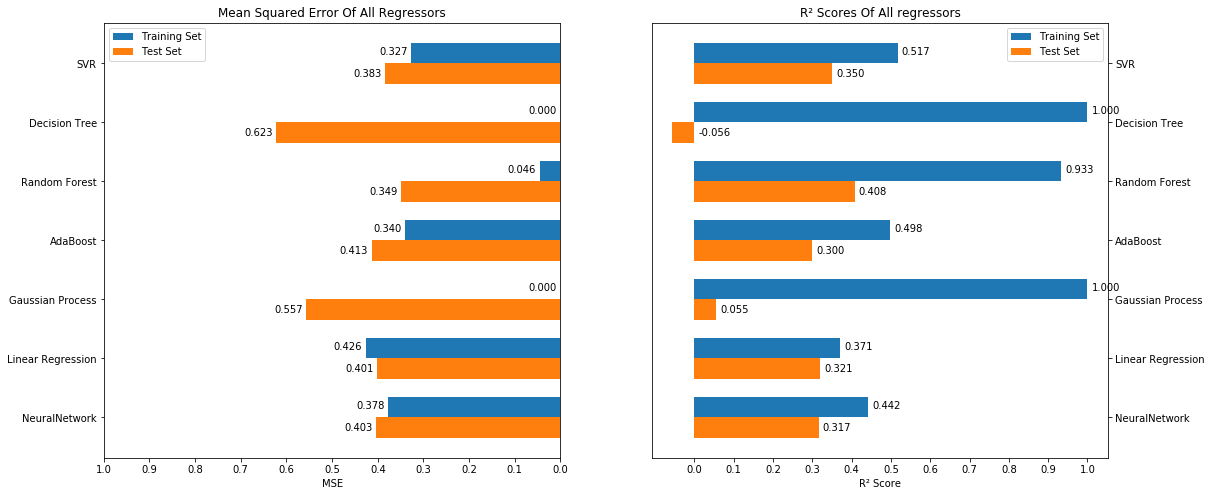

Training SVR ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...
Training GaussianProcess ...
Training LinearRegression ...
Training NeuralNetwork ...


/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/encs/pkg/anaconda3-2019.07/root/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (253) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


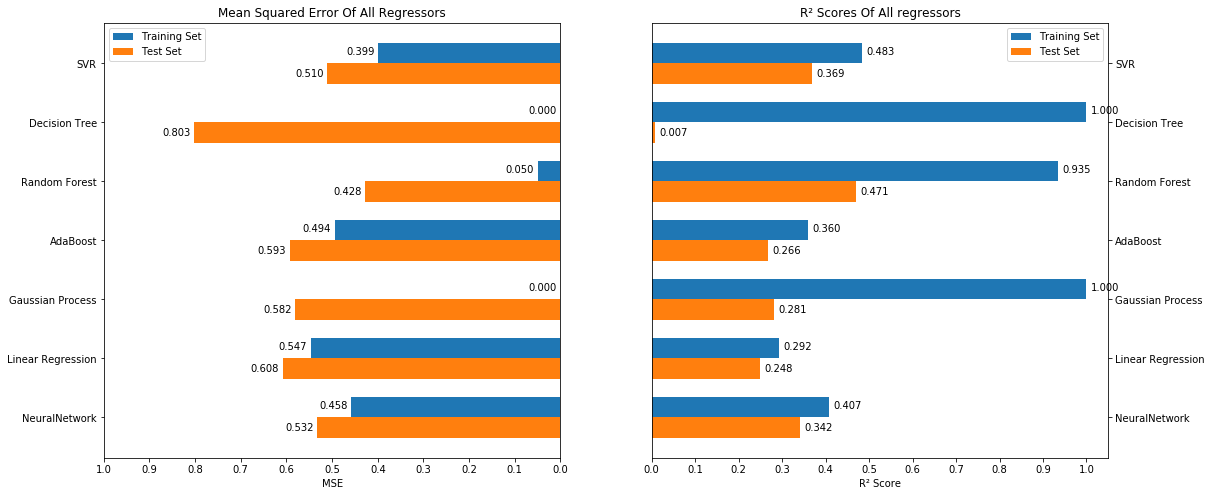

In [7]:
for df, file in zip(dfs,files):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    X_train, X_test = normalize_data(X_train, X_test)
    regrs, names = run_all_regrs(X_train, y_train, X_test, y_test)

In [8]:
# plot_all(X_train, y_train, X_test, y_test, regrs, names)